In [1]:
#Import sekcija
import numpy as np
import pandas as pd
import seaborn as sbn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn import svm

# Opis skupa podataka

### Heart Disease 
Skup podataka kojim se opisuje stanje pacijenata koji boluju od srčane bolesti tj. pokazuje uz pomoć parametara krvne slike, godina starosti i pola da li je pacijent srčani bolesnik ili ne.
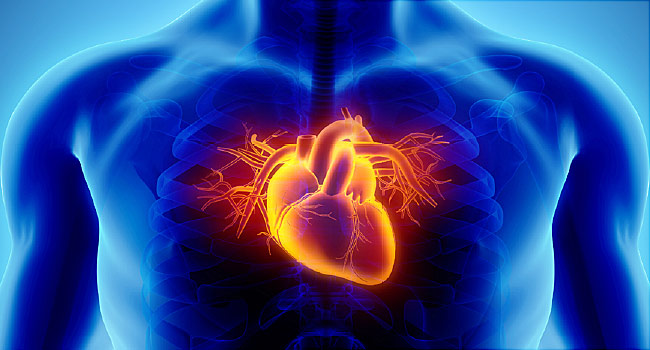

In [2]:
#Heart Disease dataset > Funkcija za čitanje skupa podataka
def getHeartDiseaseDataset():
        return pd.read_csv("heart.csv");

In [3]:
#Čitanje Heart Disease skupa podataka i prikaz
data = getHeartDiseaseDataset()
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


U tabeli iznad možemo videti 13 parametara pomoću kojih če model klasifikovati pacijente da li spadaju u srčane bolesnike ili ne. Poslednji 14. parametar #target je zapravo labela koja pokazuje da li je pacijent srčani bolesnik. 1-Pacijent je srčani bolesnik, 0-Pacijent nije srčani bolesnik.
Prvih 13 parametara skupa podataka su:

### Karakteristike

1. age Godine pacijenta.

2. sex Pol pacijenta: 1-muško 0-žensko

3. cp Chest-pain type: Tip bola u grudima
    1-tipična angina
    2-atipična angina
    3-anginalni bol
    4-asiptomatični
    
4. trestbps Vrednost krvnog pritiska u mirovanju pojedinog pacijenta.

5. chol Predstavlja holesterol.

6. fbs Upoređuje vrednost šećera u krvi pojedinca sa 120mg/dl.
    Ako je šećer u krvi veći od 120mg/dl. onda je vrednost obeležija jednaka 1.
    U protivnom vrednost obeležija je jednaka 0.
    
7. restecg Prikazuje rezultate elektrokardiografije u mirovanju.

8. thalach Prikazuje maksimalni puls koji je postigao pojedini pacijent.

9. exang Angina izazvana vežbanjem. 1-da, 0-ne.

10. Depresija izazvana vežbanjem.

11. Vršena vežba:
    1. 1 = Uzdizanje
    2. 2 = Fiksiranje
    3. 3 = Padanje
    

12. Broj glavnig sudova(0 - 3) obojenih flourozopijom.

13. thal Prikazuje talasemiju.
    1. 3 = Normalna.
    2. 6 = Fiksni defekt.
    3. 7 = Reverzibilan defekt.

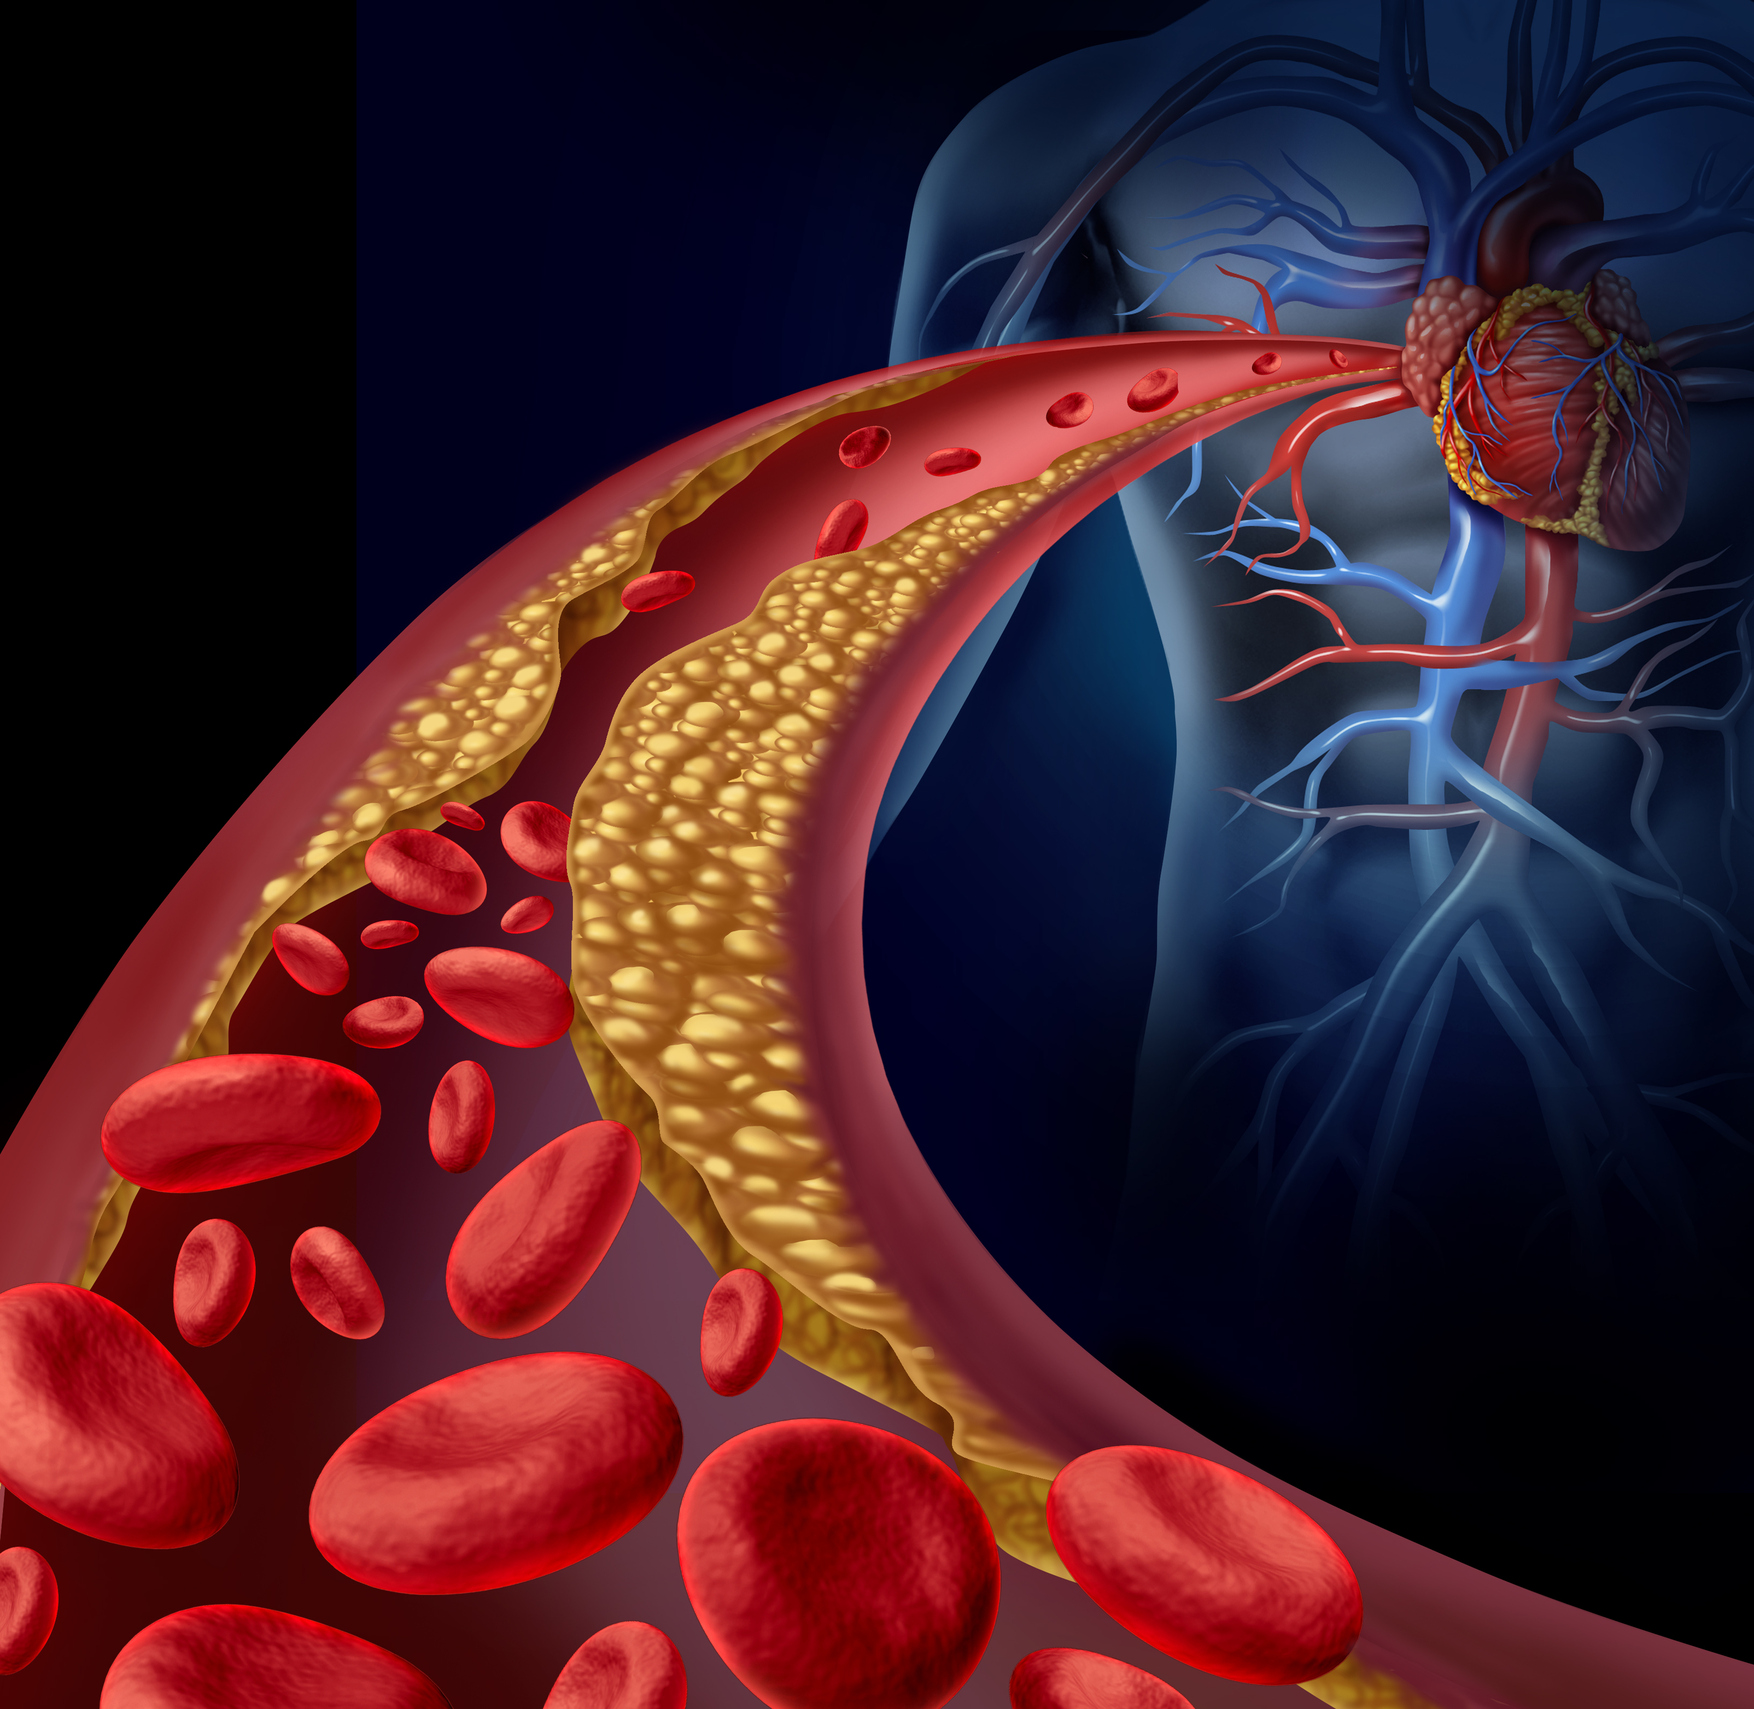

In [4]:
#Čišćenje podataka > Funkcija koja cisti podatke
def clearData(data):
    datac = data
    datac.loc[datac['ca']==4, 'ca'] = np.NaN
    datac.loc[datac['thal']==0, 'thal'] = np.NaN
    datacr = datac.fillna(datac.median())
    return datacr
    

In [5]:
#Priprema podataka > Funkcija koja odvaja labelu target labelu od parametara-obeležija koja su nam od interesa
def prepareData(data):
        X_data = data.iloc[:,:13].values; #Podaci
        Y_data = data.iloc[:,13].values; #Labele
        return X_data, Y_data

In [6]:
#Podela skupa podataka na podatke za trenig i testiranje modela.
def splitData(split_size, X_data, Y_data, random_state):
        X_data_train, X_data_test, Y_data_train, Y_data_test = train_test_split(X_data, Y_data,test_size = split_size,random_state = random_state)
        return X_data_train, X_data_test, Y_data_train, Y_data_test

In [7]:
#Skaliranje vrednosti obeležija na opseg [-1, 1]
def scaleDataFeatures(X_train, X_test):
        sc = StandardScaler()
        X_tr = sc.fit_transform(X_train)
        X_te = sc.fit_transform(X_test)
        return X_tr, X_te


In [8]:
#Klasifikator K-najbližih suseda > Funkcija koja vraća istreniran KN klasifikator
def KNclassifier(X_tr, Y_tr, nn, metrics):
        classifier =  KNeighborsClassifier(n_neighbors = nn, metric = metrics)
        classifier.fit(X_tr, Y_tr)
        return classifier

In [9]:
#Predviđanje za KN klasifikator > Funkcija koja vrši predikciju KN klasifikatora 
def KNpredict(X_te):
        Y_pred = classifier.predict(X_te)
        return Y_pred

In [10]:
#SVM klasifikator > Funkcija koja vraća istreniran SVM klasifikator
def SVMclassifier(X_tr, Y_tr, kernel):
    classifier = svm.SVC(kernel = kernel)
    classifier.fit(X_tr, Y_tr)
    return classifier

In [11]:
#DT klasifikator > Funkcija koja vraća istreniran DT klasifikator
def DTclassifier(X_tr, Y_tr ,depth):
    clssifier = DecisionTreeClassifier(max_depth = depth)
    classifier.fit(X_tr, Y_tr)
    return classifier

In [12]:
#RF klasifikator > Funkcija koja vraća istreniran RF klasifikator
def RFclassifier(X_tr, Y_tr, estimators, random_state):
            classifier = RandomForestClassifier(n_estimators = estimators, random_state = random_state)
            classifier.fit(X_tr, Y_tr)
            return classifier

In [13]:
#Funkcija koja pokazuje broj uzoraka po obeležijima koji su jednaku nuli
def countNullFeatures(data):
        data.isnull().sum()

        data['target'] = data.target.map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})
        data['sex'] = data.sex.map({0: 'female', 1: 'male'})
        data['thal'] = data.thal.fillna(data.thal.mean())
        data['ca'] = data.ca.fillna(data.ca.mean())
        print (data)

In [14]:
#Funkcija koja vraća istreniran RFE objekat
def RFeliminator(classifier, num_of_features, verbose):
        rfe = RFE(classifier, num_of_features, verbose)
        return rfe

# Priprema skupa podataka za analizu

Kako bi smo sproveli što uspešniju analizu podataka, potrebno je da predhodno pripremimo sam skup podataka koji analiziramo.
Prvo šta ćemo uraditi jeste da ćemo prebrojati null vrednosti obeležija skupa podataka

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


<AxesSubplot:>

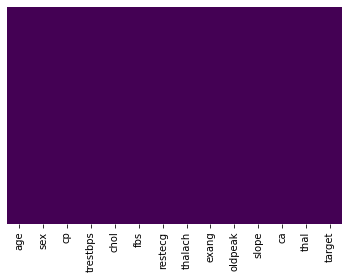

In [15]:
print(data.isna().sum())
sbn.heatmap(data.isna(),yticklabels=False, cbar=False, cmap='viridis')

Kao što možemo videti u ovom skupu podataka nemamo null vrednosti obeležija.

#### Kardinalnost obeležija

Šta predstavlja kardinalnost obeležija jednog skupa podataka? Kardinalnost obeležija je zapravo pokazatelj koliko ima različitih vrednosti za dato obeležije skupa podataka.
##### Primer
Kod skupa podataka koji opisuje pacijente obolelih od srčanih bolesti, onda bi za obeležije pol pacijenta kardinalnost bila dva:
1. Muško.

2. Žensko.

Vratimo se na Heart Disease skup podataka i hajde da vidimo kardinalnost njegovih obeležija:

In [16]:
data.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

Vidimo da je za atribut thal koji prikazuje talasemiju kardinalnost jednaka 4. Kako nam u karakteristima stoji da ovo obeležije treba imati kardinalnost 3, odnosno tri moguće vrednosti, ovu grešku moramo ispraviti. Takođe, vidimo da obeležije ca- tip bola u grudima može imati samo 4 vrednosti, tako da i to treba ispraviti. 

In [17]:
data.ca.unique()

array([0, 2, 1, 3, 4], dtype=int64)

Izbacićemo poslednju vrednost i staviti vrednost NaN

In [18]:
data.loc[data['ca']==4, 'ca'] = np.NaN
data.ca.unique()

array([ 0.,  2.,  1.,  3., nan])

In [19]:
data.loc[data['thal']==0, 'thal'] = np.NaN
data.thal.unique()

array([ 1.,  2.,  3., nan])

Sada ćemo ponovo prebrojati null vrednosti obeležija.

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          5
thal        2
target      0
dtype: int64


<AxesSubplot:>

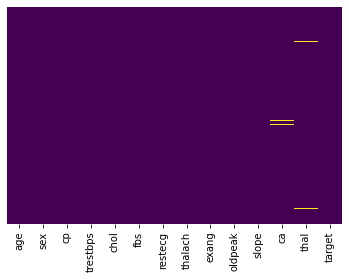

In [20]:
print(data.isna().sum())
sbn.heatmap(data.isna(),yticklabels=False, cbar=False, cmap='viridis')

Kada smo korigovali naša obeležija od sitnih grešaka vidimo da smo dodali nekolino null vrednosti.


### Tehnike za otklanjanje null vrednosti:
1. Prvi način za otklanjanje vrednosti koje nedostaju jeste ta da obrišemo ceo uzorak koji ima null vrednist.

2. Druga tehnika za rešavanje ovog problema je kreiranje odvojenog modela.

3. Treća tehnika se zasniva na statističkim metodama.

#### Brisanje uzorka

Najjednostavni način za rešavanje ovakvog problema je, kako smo rekli, brisanje svih uzoraka koji poseduju null vrednost. Prednost ovog pristupa je jednostavnost, dok je mana to što se bez velikih posledica na tačnost modela, ovaj pristup može upotrebiti na velike skupove podataka sa oko minimum 1000000 uzoraka.


#### Kreiranje odvojenog modela

Kreiranjem zasebnog modela možemo doći do vrednosti koje nam nedostaju i to na sledeći način:

1. Prvo odvajamo uzorke iz skupa koji nemaju null vredosti u skup pdataka za trening.

2. Potom odvojimo obeležije novog trening skupa koje sadrži null vrednost od ostalih, jer ćemo to obeležije koristiti kao ciljnu vrednost u zasebnom modelu.

3. Kreiramo zasebni model i treniramo na novom trenig skupu podataka.

4. Nakon treniranja modela, koristrimo odvojene podatke iz skupa koji sadrže null vrednosti, propuštamo ih kroz model kako bi smo dobili izlaz sa kojim ćemo popuniti null vrednost.

#### Nedostaci tehnike kreiranja odvojenog modela

Nedostaci ovog metoda jssu, utrošak vremena na treniranje odvojenog modela i dobijanje vrednosti.
Ako skup podataka ima više obeležija kod kojih postoje null vrednosti, morali bi za svako obeležije kreirati i trenirati odvojeni model, tako da nije preporuččjivo koristiti kod velikih skupova podataka.

#### Statističke metode

Ovo je najčešće korišćena metoda. Kod ove metode se null vrednosti obeležija popunjavaju:

1. Aritmetičkom sredinom vrednosti obeležija(mean).

2. Sredinom vrednosti obeležija. Sortiraju se vrednosti potom se bira vrednost u sredini(median).

3. Vrednost sa najvećom frekvencijom(mode).

Kako skup podataka koji analiziramo nije veliki, nećemo brisati uzorke koji sadrže null vrednosti.

Što znači da bi smo morali kreirati dva odvojena modela, trenirati ih i potom skup podataka punili vrednostima, što je malo složeniji zadatak. Zbog svega navedenog ćemo za našu analizu koristiti statističu metodu sredina vrednosti obeležija jer su oba obeležija kategorički podaci.

In [21]:
datac = data.fillna(data.median())
datac.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

# Analiza Heart Disease skupa podataka

Hajde da vidimo koliko ima obolelih u odnosu na godine i pol kod naših uzoraka. 

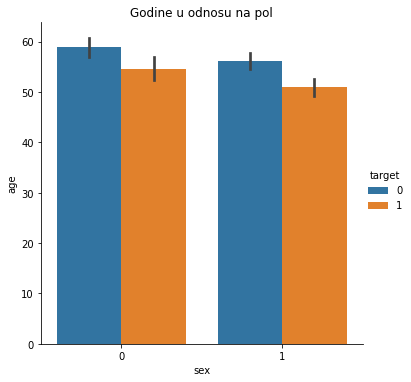

In [22]:
data = getHeartDiseaseDataset() #Čitanje skupa podataka

# Crtanje grafika
sbn.catplot(kind = 'bar', data = data, y = 'age', x = 'sex', hue = 'target')
plt.title('Godine u odnosu na pol')
plt.show()

Iz ovog prikaza možemo videti da žene sa srčanim oboljenjima su starije od muškaraca sa srčanim oboljenjima.

Hajde da vidimo koliko ima zdravih, a koliko obolelih u ovom skupu pdoataka

In [23]:
data.target.value_counts()

1    165
0    138
Name: target, dtype: int64

Pogledajmo zavisnost između obeležija.

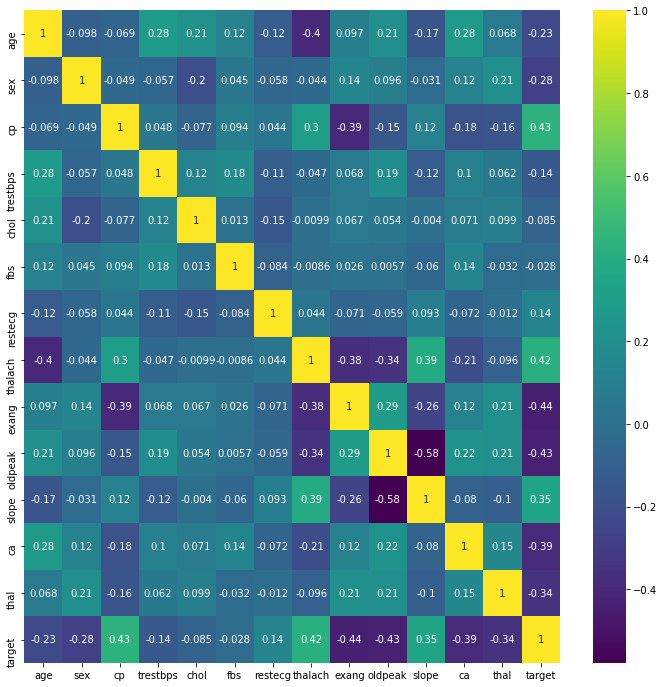

In [57]:
#printCorelation > Funkcija koja štampa korelaciju između obeležija
def printCorelation(data):
    plt.figure(figsize = (12, 12))
    sbn.heatmap(data.corr(), annot=True, cmap='viridis', 
    xticklabels=data.columns,
    yticklabels=data.columns)
    
printCorelation(data) 

# Klasifikacja metodom K najbližih suseda
Metoda K najbližih suseda se zasniva na jednom od osnovnih algoritama prepoznavanja uzoraka čiji su koraci sledeći:
1. Za novi uzorak na osnovu obeležija i odabrane metrike proračunava sličnost(daljinu) između novog uzorka i elemenata u koji su raspoređeni.
2. Distanca između novog uzorka i svakog od elemenata stavlja u polje i sortira.
3. iz sortirane liste se uzima prvih k elemenata.
4. Potom se od k elemenata prebrojava maksimalan broj elemenata koji pripadaju istoj grupi
5. Na kraju se novi uzorak dodeljuje grupi koja od prvih k elemenata u polju ima najviše pripadnika.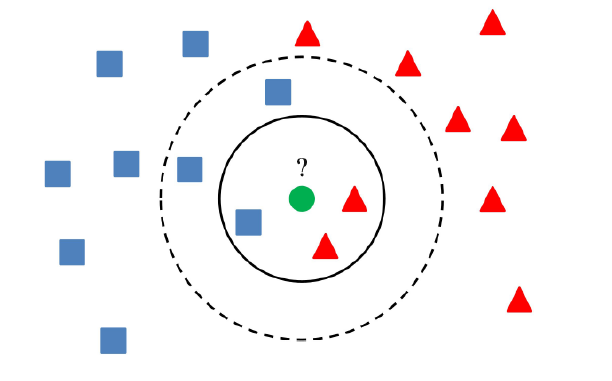 

# Klasifikacija za K = 5

In [25]:
#Klasifikacija
#data = getHeartDiseaseDataset() #Čitanje podataka
x_data, y_data = prepareData(datac) #Priprema podataka
x_train, x_test, y_train, y_test = splitData(0.2, x_data, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti.
Kclassifier = KNclassifier(x_strein_data, y_train, 5, 'euclidean') #KNklasifikator
y_predict = Kclassifier.predict(x_stest_data) #Predikcija
accurancy = metrics.accuracy_score(y_test, y_predict) #Proračun tačnsoti
print('Tačnost: ', accurancy)

Tačnost:  0.7704918032786885


# Klasifikacija za K = 7

In [26]:
#Klasifikacija
#data = getHeartDiseaseDataset() #Čitanje podataka
x_data, y_data = prepareData(datac) #Priprema podataka
x_train, x_test, y_train, y_test = splitData(0.2, x_data, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti.
Kclassifier = KNclassifier(x_strein_data, y_train, 7, 'euclidean') #KNklasifikator
y_predict = Kclassifier.predict(x_stest_data) #Predikcija
accurancy = metrics.accuracy_score(y_test, y_predict) #Proračun tačnsoti
print('Tačnost: ', accurancy)

Tačnost:  0.7540983606557377


# Klasifikacija za K = 9

In [27]:
#Klasifikacija
#data = getHeartDiseaseDataset() #Čitanje podataka
x_data, y_data = prepareData(datac) #Priprema podataka
x_train, x_test, y_train, y_test = splitData(0.2, x_data, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti.
Kclassifier = KNclassifier(x_strein_data, y_train, 9, 'euclidean') #KNklasifikator
y_predict = Kclassifier.predict(x_stest_data) #Predikcija
accurancy = metrics.accuracy_score(y_test, y_predict) #Proračun tačnsoti
print('Tačnost: ', accurancy)

Tačnost:  0.7704918032786885


# Klasifikacija za K = 5 Kosinusna metrika

In [28]:
#Klasifikacija
#data = getHeartDiseaseDataset() #Čitanje podataka
x_data, y_data = prepareData(datac) #Priprema podataka
x_train, x_test, y_train, y_test = splitData(0.2, x_data, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti.
Kclassifier = KNclassifier(x_train, y_train, 5, 'cosine') #KNklasifikator
y_predict = Kclassifier.predict(x_test) #Predikcija
accurancy = metrics.accuracy_score(y_test, y_predict) #Proračun tačnsoti
print('Tačnost: ', accurancy)

Tačnost:  0.6721311475409836


# Klasifikacija za K = 7 Kosinusna metrika

In [29]:
#Klasifikacija
#data = getHeartDiseaseDataset() #Čitanje podataka
x_data, y_data = prepareData(datac) #Priprema podataka
x_train, x_test, y_train, y_test = splitData(0.2, x_data, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti.
Kclassifier = KNclassifier(x_strein_data, y_train, 7, 'cosine') #KNklasifikator
y_predict = Kclassifier.predict(x_stest_data) #Predikcija
accurancy = metrics.accuracy_score(y_test, y_predict) #Proračun tačnsoti
print('Tačnost: ', accurancy)

Tačnost:  0.7377049180327869


# Klasifikacija za K = 9 Kosinusna metrika

In [31]:
#Klasifikacija
#data = getHeartDiseaseDataset() #Čitanje podataka
x_data, y_data = prepareData(datac) #Priprema podataka
x_train, x_test, y_train, y_test = splitData(0.2, x_data, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti.
Kclassifier = KNclassifier(x_strein_data, y_train, 7, 'cosine') #KNklasifikator
y_predict = Kclassifier.predict(x_stest_data) #Predikcija
accurancy = metrics.accuracy_score(y_test, y_predict) #Proračun tačnsoti
print('Tačnost: ', accurancy)

Tačnost:  0.7377049180327869


Kao što vidimo iz predhodnih primera, tačnost se može povećati ili smanjiti promenom broja uzetih suseda i promenom metrike. Kako bi smo saznali koji je broj suseda najoptimalni za naš model koristćemo Cross-validation metodu za svaki broj suseda suseda, u našem slučaju od 1 do 50 suseda.

# Cross-validation metoda
je metoda kojom se vrši treniranje modela u ovom slučaju KNN klasifikatora za svaku moguću vrednost, u ovom slučaju broja suseda k i proračunava tačnost modela.Cross-validation metoda kroz određeni broj iteracija deli skup podataka na skup za trening i test. Nakon proračunavanja tačnosti, zamenjuje testni i trening skup. U ovom slučaju ćemo izvršiti cross validaciju za svaki broj suseda od 1 do 50 i videti koja je najoptimalnija vrednost. Najoptimalnija vrednost za broj suseda k će biti vrednost za koju model daje najveću tačnost.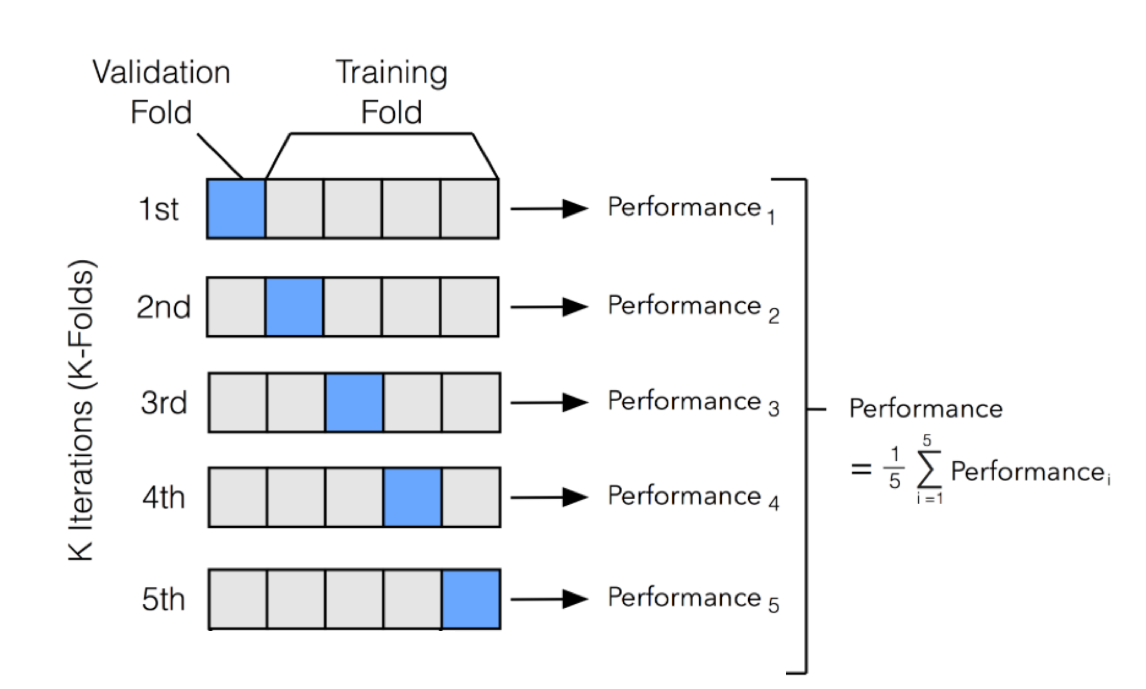

In [32]:
#Metoda za Cross validaciju.
def KNeighborsCrossValidation(neighbors):
    cross_scores = []
    #data = getHeartDiseaseDataset() #Čitanje podataka
    x_data, y_data = prepareData(datac) #Priprema podataka
    sc = StandardScaler()
    x_tr = sc.fit_transform(x_data)
    
    for k in neighbors:
        
        classifier = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(classifier,  x_tr, y_data, cv=10, scoring='accuracy')
        cross_scores.append(scores.mean())
    
    return cross_scores

neighbors = list(range(1, 50, 2))
cs = KNeighborsCrossValidation(neighbors)


mean_sq_error = [1 - s for s in cs]
optimalK = neighbors[mean_sq_error.index(min(mean_sq_error))]
print('Najoptimalnija vrednost za k je = ',optimalK)
cs

Najoptimalnija vrednost za k je =  25


[0.7556989247311827,
 0.8119354838709677,
 0.8251612903225807,
 0.8317204301075269,
 0.8317204301075269,
 0.8216129032258065,
 0.824731182795699,
 0.8248387096774193,
 0.8312903225806452,
 0.8347311827956989,
 0.8281720430107526,
 0.831505376344086,
 0.8381720430107527,
 0.8316129032258065,
 0.8349462365591398,
 0.8316129032258065,
 0.8316129032258065,
 0.831505376344086,
 0.8281720430107526,
 0.8248387096774193,
 0.821505376344086,
 0.821505376344086,
 0.8181720430107526,
 0.821505376344086,
 0.824731182795699]

Sada ćemo da proverimo dobijeni rezultat

# Klasifikacija za K = 25

In [37]:
#Klasifikacija
#data = getHeartDiseaseDataset() #Čitanje podataka
x_data, y_data = prepareData(datac) #Priprema podataka
x_train, x_test, y_train, y_test = splitData(0.1, x_data, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti.
Kclassifier = KNclassifier(x_strein_data, y_train, 25, 'euclidean') #KNklasifikator
y_predict = Kclassifier.predict(x_stest_data) #Predikcija
accurancy = accurancy = metrics.accuracy_score(y_test, y_predict) #Proračun tačnsoti
print('Tačnost: ', accurancy)

Tačnost:  0.8709677419354839


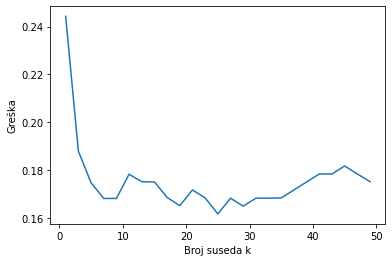

In [38]:
plt.plot(neighbors, mean_sq_error)
plt.xlabel('Broj suseda k')
plt.ylabel('Greška')
plt.show()

Iz slike grafika se može videti da je srednja kvadratna greška najmanja blizu broja 10 suseda.

# SVM Klasifikacija (Support Vector Machines)
Kod SVM klasifikacije potrebno je pronaći hiperravan koja razdvaja podatke koji pripadaju različitim klasama.
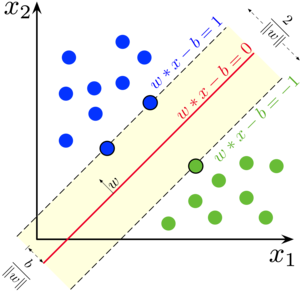
#### Šta je hiperravan?
Sam pojam hiperravn se vezuje za bilo koji podprostor nekog prostora dimezije n, čija je dimenzija n-1. Treba uočiti da je ovaj podprostor(hiperravan) u prostorima čija je dimenzija za jedan veća od njegove.

Na primer u jednodimenzionalnom prostoru, kao što je linija, hiperravan je tačka. Tačka deli liniju na dva dela.
U dvodimenzionalnom prostoru kao što je ravan, hiperravan je prava. Prava deli ravan na dve polu ravni. U trodimenzionalnom prostoru, hiperravan je bilo koja ravan koja deli prostor na dva pod prostora.

# SVM klasifikacija Linear kernel

In [39]:
#Klasifikacija
#data = getHeartDiseaseDataset() #Čitanje podataka
x_data, y_data = prepareData(datac) #Priprema podataka
x_train, x_test, y_train, y_test = splitData(0.3, x_data, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti.
classifier = SVMclassifier(x_strein_data, y_train, 'linear')
y_predict = classifier.predict(x_stest_data) #Predikcija
accurancy = accurancy = metrics.accuracy_score(y_test, y_predict) #Proračun tačnsoti
print('Tačnost: ', accurancy)

Tačnost:  0.7912087912087912


# SVM klasifikacija Polynomial kernel

In [40]:
#Klasifikacija
#data = getHeartDiseaseDataset() #Čitanje podataka
x_data, y_data = prepareData(datac) #Priprema podataka
x_train, x_test, y_train, y_test = splitData(0.1, x_data, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti.
classifier = SVMclassifier(x_strein_data, y_train, 'poly')
y_predict = classifier.predict(x_stest_data) #Predikcija
accurancy = accurancy = metrics.accuracy_score(y_test, y_predict) #Proračun tačnsoti
print('Tačnost: ', accurancy)

Tačnost:  0.8709677419354839


# SVM klasifikacija Sigmoid kernel

In [41]:
#Klasifikacija
#data = getHeartDiseaseDataset() #Čitanje podataka
x_data, y_data = prepareData(datac) #Priprema podataka
x_train, x_test, y_train, y_test = splitData(0.1, x_data, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti.
classifier = SVMclassifier(x_strein_data, y_train, 'sigmoid')
y_predict = classifier.predict(x_stest_data) #Predikcija
accurancy = accurancy = metrics.accuracy_score(y_test, y_predict) #Proračun tačnsoti
print('Tačnost: ', accurancy)

Tačnost:  0.9032258064516129


# Klasifikacija stablom odlučivanja
Stablo odlučivanja može vršiti klasifikaciju podataka rekurzivno tako što će deliti skup podataka na manje podskupove, nakon toga podskupove na još manje pod skupove. Klasifikacija podataka stablom odlučivanja se vrši na sledeći način:
1. U korenu stabla biće obuhvaćen celi skup podataka.
2. Algoritam će potražiti obeležije i na osnovu određenog kriterijuma će izvršiti podelu.
3. U prvom nivou podaci se dele na osnovu prvog odabranog obeležija skupa.
4. U narednim koracima se dalji podskupovi dele na osnovu sledećih odabranih karakteristika.
Kriterijumi po kojima se vrši zaustavljanje su:

1. Svi ili skoro svi podaci pripadaju istoj klasi.
2. Nema više obeležija skupa po kome bi se vršila podela.
3. Stablo je dostiglo unapred definisanu veličinu.
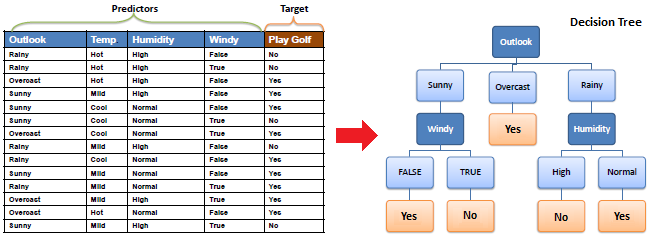

Listovi u stablu predstavljaju podskupove podataka koji pripadaju samo jednoj klasi.
Sada ćemo izvršiti klasifikaciju stablom.

In [44]:
#Klasifikacija
#data = getHeartDiseaseDataset() #Čitanje podataka
x_data, y_data = prepareData(datac) #Priprema podataka
x_train, x_test, y_train, y_test = splitData(0.1, x_data, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti.
DTrclassifier = DTclassifier(x_strein_data, y_train, 10)
y_predict = DTrclassifier.predict(x_stest_data) #Predikcija
accurancy = accurancy = metrics.accuracy_score(y_test, y_predict) #Proračun tačnsoti
print('Tačnost: ', accurancy)

Tačnost:  0.9032258064516129


# Random Forest klasifiacija
U predhodnoj klasifikaciji koristili smo stablo odlučivanja kao model. Sa stablom odlučivanja dobili smo tačnost od: 0.9032258064516129, odnosno: 0.9032258064516129X100 = 90%. Veličina test skupa 10%, a veličina trening skupa 90%. I sa drugim klasifikatorima najveću tačnost koju smo postigli je 0.9032258064516129X100 = 90%. Odradićemo još jedn klasifikaciju uz pomoć random forest klasifikatora.
###Random Forest
Random Forest algoritam će kako mu samo ime kaže formirati šumu stabala i pokušati da dobije što veću tačnost.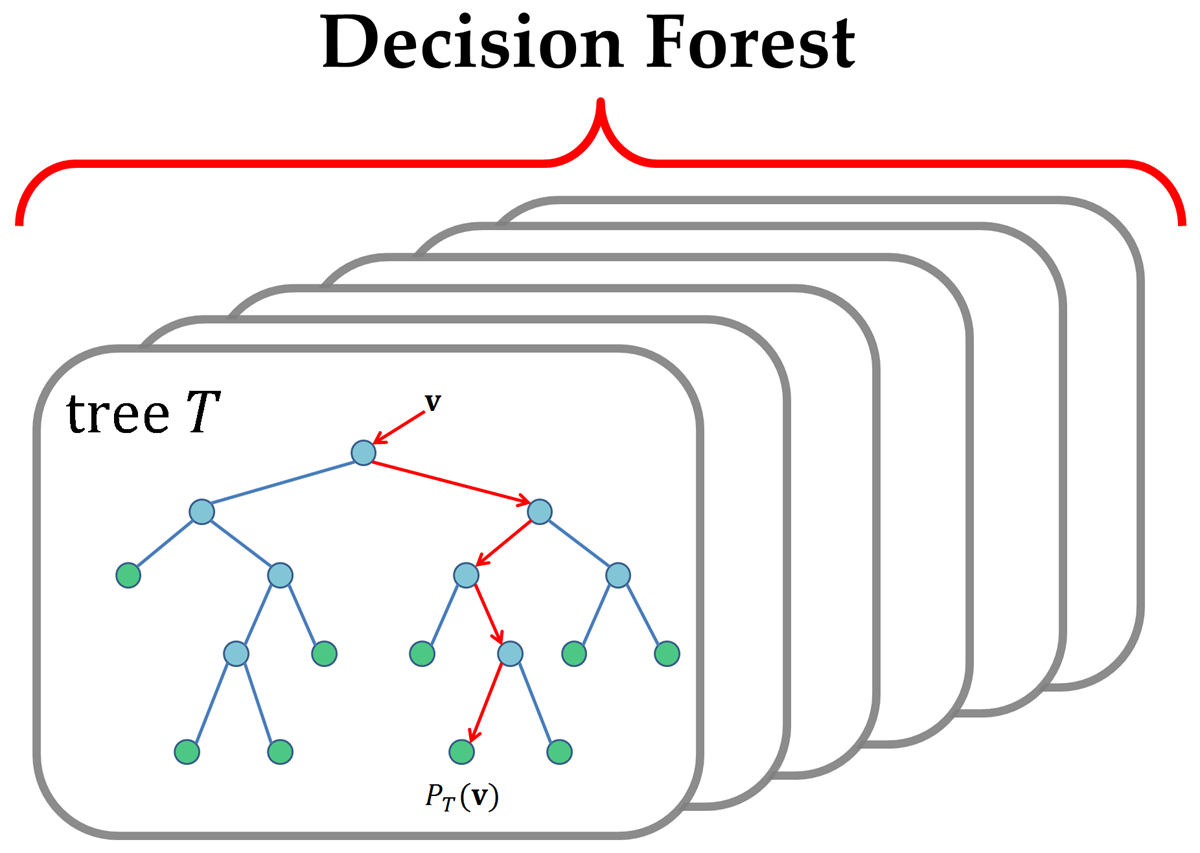

Random Forest nasumično deli skup podataka na manje podskupove 
i na osnovu tih pod skupova izrađuje stabla odlučivanja.
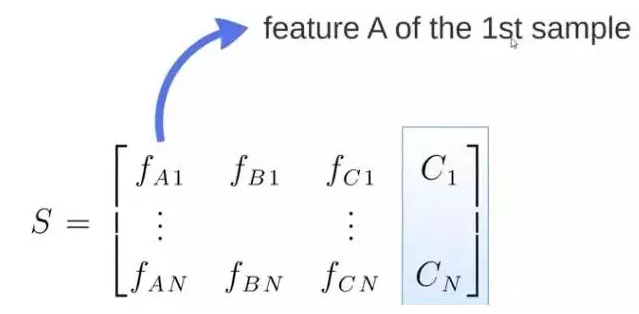

### Podala na podskupove
Kao što vidimo na slici iznad imamo jednu matricu koja predstavlja podskup podataka.
Element matrice Fa1 predstavlja obeležije A prvog uzorka celokupnog skupa itd.

Na osnovu ove matrice algoritam generiše stablo odlučivanja. Kako smo rekli, algoritam deli skup na podskupove
tj. za svaki podskup generiše ovakvu matricu i nakon toga izrađuje stabla odlučivanja.

# RF klasifikacija

In [45]:
#Klasifikacija
#data = getHeartDiseaseDataset() #Čitanje podataka
x_data, y_data = prepareData(datac) #Priprema podataka
x_train, x_test, y_train, y_test = splitData(0.1, x_data, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti.
rfclassifier = RFclassifier(x_strein_data, y_train, 100, 42)
y_predict = rfclassifier.predict(x_stest_data) #Predikcija
accurancy = accurancy = metrics.accuracy_score(y_test, y_predict) #Proračun tačnsoti
print('Tačnost: ', accurancy)

Tačnost:  0.9032258064516129


Kako vidimo i Random Forest model je dao iste rezultate. Postavlja se pitanje kako da unapredimo naše Machine learning modele i povećamo njihovu tačnos? Hajde da pogledamo naš skup podataka, odnosno njegova obeležija. Naš skup podataka sadrži podatke o srčanim bolesnicima tj. ljudima koji pate od srčanih oboljenja i onih koji nisu srčani bolesnici. Svakako za svaku od te dve grupe naš skup podata sadrži ista obeležija.

Skoncentrisaćemo se malo na sam skup podataka, analizirati ga i videti kakve nam informacije analiza može dati.

Možemo reći da pojedina obeležija imaju veću "težinu" pri klasifikaciji samih podataka, tako da u cilju dublje analize podataka, potrebno je obraditi algoritme za selekciju obeležija podataka. Algoritme takve vrste nazivamo Feature Selection algorutmima. 

# Feature Selection

## Rekurzivna eliminacija obeležija

Spoljašnji procenjivač dodeljuje svakom obeležiju određenu težinu. Rekurzivno eliminisanje obeležija se obavlja tako što se u svakoj iteraciji ovog algoritma uzima sve manji i manji skup samih obeležija. Na početku procenjivač biva treniran na celikupnom skupu obeležija i važnost svakog od obeležija biva dobijena kroz _coef atribut ili kroz feature_importances atribut. Nakon ovih koraka obeležije sa najmanjom vrednošću biva izbačeno iz skupa obeležija i ponovo se izvršavaju predhodni koraci na smanjenom skupu obeležija sve dok skup obeležija ne dostigne željeni zadati broj.
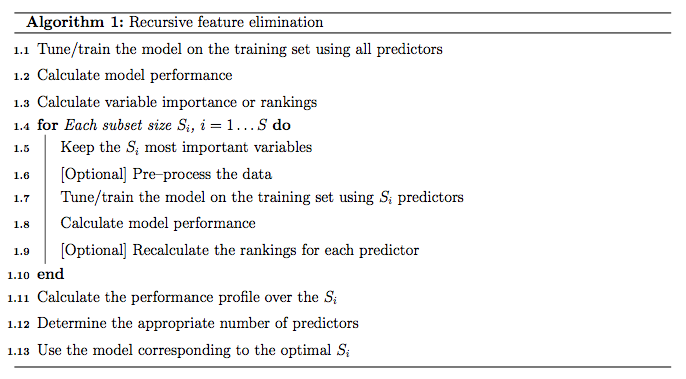

In [47]:
#data = getHeartDiseaseDataset() #Čitanje podataka
x_data, y_data = prepareData(datac) #Priprema podataka
x_train, x_test, y_train, y_test = splitData(0.1, x_data, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti.
classif =  RFclassifier(x_strein_data, y_train, 100, 42) #Klasifikator
RFel = RFeliminator(classif, 5, 1)
RFel.fit(x_strein_data,y_train)

C:\Users\Aleksandar\anaconda3\envs\Work\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=5, step=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=5)

In [48]:
XFeaures = RFel.support_


In [49]:
XFeaures

array([ True, False,  True, False, False, False, False,  True, False,
        True, False,  True, False])

Rekurzivna eliminacija obeležija nam je kao rezultat na random forest klasifikatoru dala sledećih pet obeležija:
1. godine pacijenta
2. tip bola u grudima 
3. maksimalni puls
4. depresija izazvana vežbanjem
5. broj glavnih sudova(0 - 3) obojenih flourozopijom.

In [50]:
#data = getHeartDiseaseDataset() #Čitanje podataka
del datac['target'] #Uklanjanje target kolone
XF = datac[datac.columns[XFeaures]] #Selektovanje odabranih obeležija skupa podataka
XF

,age,cp,thalach,oldpeak,ca
0,63,3,150,2.3,0.0
1,37,2,187,3.5,0.0
2,41,1,172,1.4,0.0
3,56,1,178,0.8,0.0
4,57,0,163,0.6,0.0
...,...,...,...,...,...
298,57,0,123,0.2,0.0
299,45,3,132,1.2,0.0
300,68,0,141,3.4,2.0
301,57,0,115,1.2,1.0


In [51]:

x_train, x_test, y_train, y_test = splitData(0.1, XF, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti
x_train
classi =  RFclassifier(x_strein_data, y_train, 100, 42)
y_predict = classi.predict(x_stest_data) #Predikcija
accurancy = accurancy = metrics.accuracy_score(y_test, y_predict) #Proračun tačnsoti
print('Tačnost: ', accurancy)

Tačnost:  0.7741935483870968


Vidimo da je Random Forest klasifiacija nad skupom podataka sa rekurzivno selektovanim obeležijima dala manju tačnost! Hajde da izvršimo klasifikaciju stablom odlučivanja nad skupom sa rekurzino eliminisanim obeležiima.

In [52]:
x_train, x_test, y_train, y_test = splitData(0.1, XF, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti
Trclassifier = DTclassifier(x_strein_data, y_train, 10)
y_predict = Trclassifier.predict(x_stest_data) #Predikcija
accurancy = accurancy = metrics.accuracy_score(y_test, y_predict) #Proračun tačnsoti
print('Tačnost: ', accurancy)

Tačnost:  0.8709677419354839


Ćak i sa ovim klasifikatorom dobijamo manju tačnost sa selektovanim obeležijima! Pokušajmo sa 
KNN klasifikatorom.

In [53]:
x_train, x_test, y_train, y_test = splitData(0.1, XF, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti
Klassifier = KNclassifier(x_strein_data, y_train, 9, 'euclidean') #KNklasifikator
y_predict = Klassifier.predict(x_stest_data) #Predikcija
accurancy = metrics.accuracy_score(y_test, y_predict) #Proračun tačnsoti
print('Tačnost: ', accurancy)

Tačnost:  0.8709677419354839


Iz ova tri primera možemo zaključiti, da za ovaj skup podataka rekurzivna eliminacija obeležija nam nije bila od pomoći pri povećanju tačnosti modela!  U nastavku ćemo obraditi još neke algoritme za selekciju obeležija.

# Chi-Squared test for feature selection

Hi kvadrati test za odabir obeležija se koristi kada su obežija kategorična. Meri stepen povezanosti između dva kategorička obeležija.

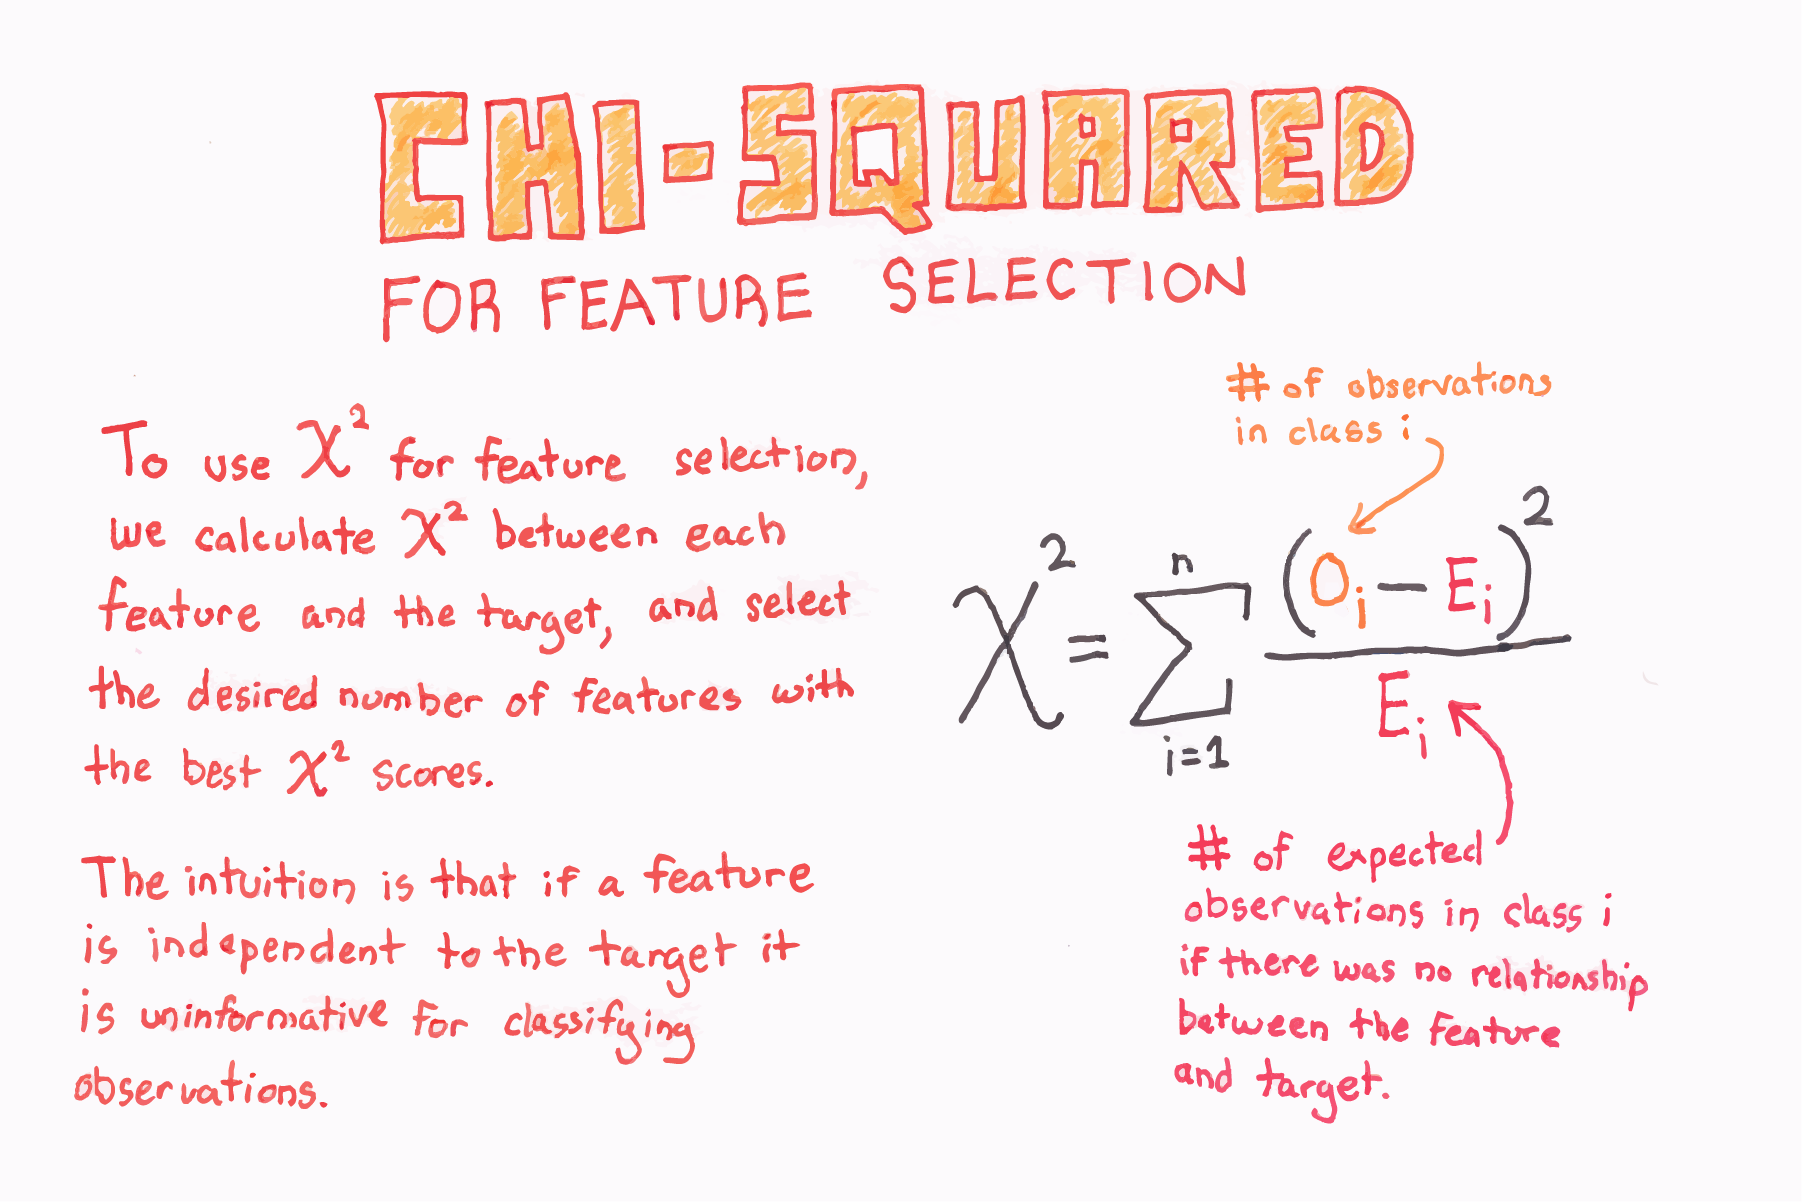

Hi kvadratna statistika se računa uz pomoć formule prikazane na slici iznad. Parapetar O predstavlja dobijenu vrednost pri proračunavanju dok E predstavlja zapravo očekivanu vrednost. Ako su O i E približno jednake vrednosti to znači da su obeležija nezavisna i da će Hi kvadratna vrednost biti visoka!

age         4.880146e-04
sex         6.175736e-03
cp          2.133283e-14
trestbps    4.676289e-03
chol        3.148221e-05
fbs         9.026030e-01
restecg     1.970803e-01
thalach     9.166021e-40
exang       1.291353e-09
oldpeak     5.542101e-13
slope       4.916830e-03
ca          9.461974e-13
thal        3.944486e-02
dtype: float64


<AxesSubplot:>

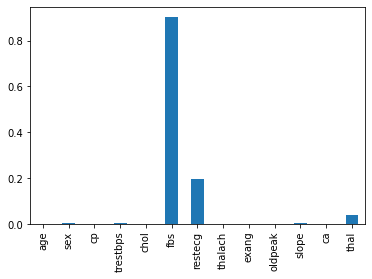

In [66]:
x_data, y_data = prepareData(data) #Priprema podataka
chid = getHeartDiseaseDataset()
del chid['target']
x_train, x_test, y_train, y_test = splitData(0.1, x_data, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti.
chi_scores = chi2(x_train, y_train)
p_values = pd.Series(chi_scores[1], index = chid.columns)
print(p_values)
p_values.plot.bar()

Kako nam obeležija:
1. thalach     9.166021e-40
2. cp          2.133283e-14
3. ca          9.461974e-13

Imaju najmanju vrednost to znači da su u velikoj korelaciji sa target vrednošću tako da ćemo samo njih uzeti u obzir.

Klasifikacja metodom K najbližih suseda K = 9

In [72]:
x_data, y_data = prepareData(data) #Priprema podataka
data2 = data[["cp", "thalach","ca"]]
x_train, x_test, y_train, y_test = splitData(0.1, data2, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti.
Kclassifier = KNclassifier(x_strein_data, y_train, 9, 'euclidean') #KNklasifikator
y_predict = Kclassifier.predict(x_stest_data) #Predikcija
accurancy = metrics.accuracy_score(y_test, y_predict) #Proračun tačnsoti
print('Tačnost: ', accurancy)

Tačnost:  0.8387096774193549


Stablo odlučivanja.

In [73]:
x_data, y_data = prepareData(data) #Priprema podataka
data2 = data[["cp", "thalach","ca"]]
x_train, x_test, y_train, y_test = splitData(0.1, data2, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti.
DTrclassifier = DTclassifier(x_strein_data, y_train, 10)
y_predict = DTrclassifier.predict(x_stest_data) #Predikcija
accurancy = accurancy = metrics.accuracy_score(y_test, y_predict) #Proračun tačnsoti
print('Tačnost: ', accurancy)

Tačnost:  0.7741935483870968


Random Forest

In [74]:
x_data, y_data = prepareData(data) #Priprema podataka
data2 = data[["cp", "thalach","ca"]]
x_train, x_test, y_train, y_test = splitData(0.1, data2, y_data, 1) #Podela skupa podataka na skup za trening i skup za test.
x_strein_data, x_stest_data = scaleDataFeatures(x_train, x_test) #Skaliranje podataka radi bržeg izračunavanja udaljenosti.
rfclassifier = RFclassifier(x_strein_data, y_train, 100, 42)
y_predict = rfclassifier.predict(x_stest_data) #Predikcija
accurancy = accurancy = metrics.accuracy_score(y_test, y_predict) #Proračun tačnsoti
print('Tačnost: ', accurancy)

Tačnost:  0.7741935483870968
